## Apply and investigate bias correction effects
Last updated: Kevin Varga, 12/27/2024

**Inputs:**
* Netcdf file of predicted and interpolated LFM of all four fuels
* Netcdf file of interpolated chamise bias corrections

**Outputs:**
* Final netcdf file of bias corrected chamise LFM, as well as all other fuel LFM

In [2]:
import xarray as xr
import pandas as pd
import numpy as np

In [3]:
# Set path
grid_path = '/home/sbarc/students/varga/nasa/ch1/data/lfm_model/'

In [4]:
# Open modeled and interpolated LFM dataset
lfm_ds = xr.open_dataset(grid_path + 'interpolated_ds.nc')
# Open chamise bias correction data array
bias_correction = xr.open_dataarray(grid_path + 'bias_correction.nc')
# Subset chamise data
da = lfm_ds['chamise']

In [5]:
# Label original predicted chamise as having no bias correction
lfm_ds = lfm_ds.rename({'chamise':'chamise_no_bias_correction'})

# Apply bias correction to chamise LFM data array
lfm_ds['chamise'] = da + bias_correction

In [17]:
# Assign attributes describing the dataset
lfm_ds = lfm_ds.assign_attrs(
    title = 
'Santa Barbara Area Chaparral Live Fuel Moisture (LFM)',
    description = 
'''LFM of four chaparral fuel types calculated using fuel specific random forest models
Predictors (in order of gini importance):
Precipitation 90-day sum, Temperature 90-day mean, Solar Radiation 150-day mean,
Daylength, Near Infrared Reflectance of Vegetation (NIRv), Soil Moisture 7-day mean,
Relative Humidity 150-day mean, Climatic Water Deficit 90-day sum, Precip 30-day sum
Predictand:
LFM observations from US National Fuel Moisture Database''',
    units = 
'LFM = (mass of dry matter) / (mass of water) x 100%',
    created = 
'2024-12-27',
    dimension_convention = 
'''WGS84 datum, standard latitude and longitude GCS, EPSG:4326
Grid based on output from Weather Research and Forecasting model,
Advanced Research WRF version 4.0.1''',
    bias_correction = 
'''Quantile mapping bias correction was performed on modeled chamise LFM
Bias corrected and non bias corrected chamise LFM included'''
)

variable_order = ['chamise','chamise_old_growth','sage_black','ceanothus_bigpod','chamise_no_bias_correction']
lfm_ds = lfm_ds[variable_order]

In [20]:
# Assign attributes to each variable
lfm_ds['chamise'] = lfm_ds['chamise'].assign_attrs(
    description = 
'''Live fuel moisture content of chamise new growth ($\it{Adenostoma}$ $\it{fasciculatum}$)
Bias corrected using observations via quantile mapping'''
)

lfm_ds['chamise_old_growth'] = lfm_ds['chamise_old_growth'].assign_attrs(
    description = 'Live fuel moisture content of chamise old growth ($\it{Adenostoma}$ $\it{fasciculatum}$)'
)

lfm_ds['sage_black'] = lfm_ds['sage_black'].assign_attrs(
    description = 'Live fuel moisture content of black sage ($\it{Salvia}$ $\it{mellifera}$)'
)

lfm_ds['ceanothus_bigpod'] = lfm_ds['ceanothus_bigpod'].assign_attrs(
    description = 'Live fuel moisture content of bigpod ceanothus ($\it{Ceanothus}$ $\it{megacarpus}$)'
)

lfm_ds['chamise_no_bias_correction'] = lfm_ds['chamise_no_bias_correction'].assign_attrs(
    description = 
'''Live fuel moisture content of chamise ($\it{Adenostoma}$ $\it{fasciculatum}$)
NOT Bias corrected'''
)

In [21]:
# Save final dataset output
lfm_ds.to_netcdf(grid_path + 'sba_lfm_1987-2019.nc')

### Below code can be used to explore bias correction at different time steps

In [24]:
def da_extreme_values(da):
    """Generate max and min values of individual time steps for an xarray DataArray."""
    # Calculate max and min across the spatial domain for every time step
    import datetime as dt
    ts_max = da.max(dim=['latitude', 'longitude'])
    ts_min = da.min(dim=['latitude', 'longitude'])

    # Sort the indices of the data array in descending order
    max_sorted_indices = ts_max.argsort()[::-1]
    # Select the first 20 indices from the sorted indices
    max_20_indices = max_sorted_indices[:30].values
    max_20_times = pd.to_datetime(ts_max['time'].isel(time=max_20_indices).values)

    # Sort the indices of the data array in ascending order
    min_sorted_indices = ts_min.argsort()
    # Select the first 20 indices from the sorted indices
    min_20_indices = min_sorted_indices[:30].values
    min_20_times = pd.to_datetime(ts_max['time'].isel(time=min_20_indices).values)

    # Get the top 20 max and min values along with their corresponding time steps
    max_20_values = ts_max.isel(time=max_20_indices).values
    min_20_values = ts_min.isel(time=min_20_indices).values

    # Print the results
    #print("Top 20 Maximum Values:")
    #print(max_20_indices)
    #print(max_20_times)
    #print(max_20_values)

    #print("\nTop 20 Minimum Values:")
    #print(min_20_indices)
    #print(min_20_times)
    #print(min_20_values)

    # Return the results as a dictionary
    results = {
        "max_20_indices": max_20_indices,
        "max_20_times": max_20_times,
        "max_20_values": max_20_values,
        "min_20_indices": min_20_indices,
        "min_20_times": min_20_times,
        "min_20_values": min_20_values
    }
    return results

In [25]:
# Identify time steps when bias correction has greatest positive and negative corrections
ex_values = da_extreme_values(bias_correction)

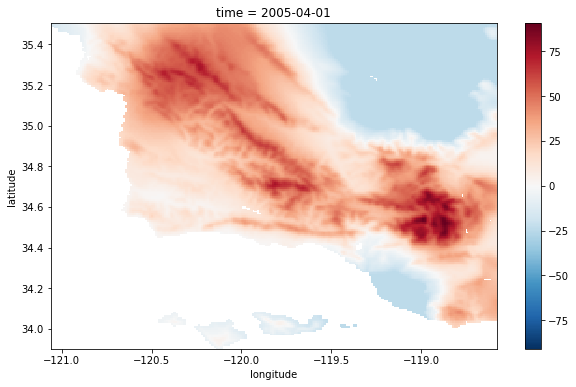

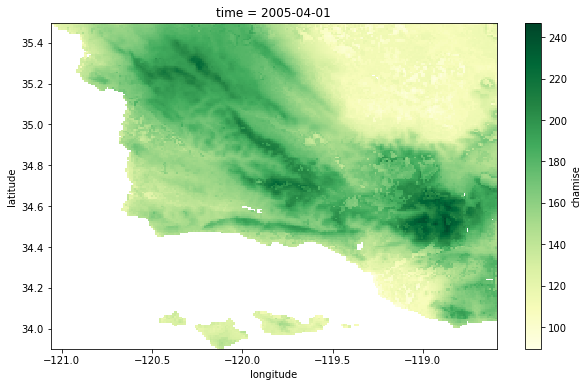

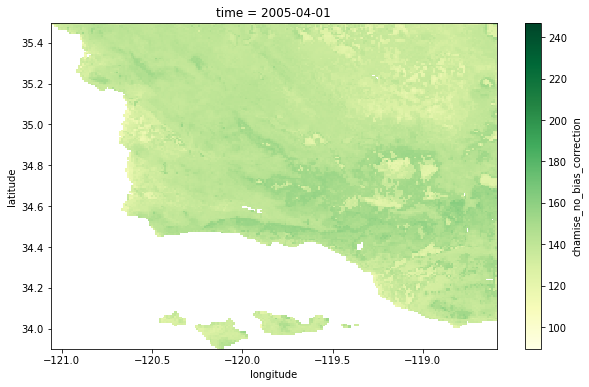

In [28]:
# Check bias correction, original chamise, and corrected chamise plots of time steps with largest positive correction
# i = 0 refers to largest positive correction
i =0
min_value = lfm_ds['chamise'].sel(time=ex_values['max_20_times'][i]).min()
max_value = lfm_ds['chamise'].sel(time=ex_values['max_20_times'][i]).max()
bias_correction.sel(time=ex_values['max_20_times'][i]).plot(figsize=[10,6]);
lfm_ds['chamise'].sel(time=ex_values['max_20_times'][i]).plot(figsize=[10,6], vmin=min_value, vmax=max_value, cmap='YlGn');
lfm_ds['chamise_no_bias_correction'].sel(time=ex_values['max_20_times'][i]).plot(figsize=[10,6], vmin=min_value, vmax=max_value, cmap='YlGn');

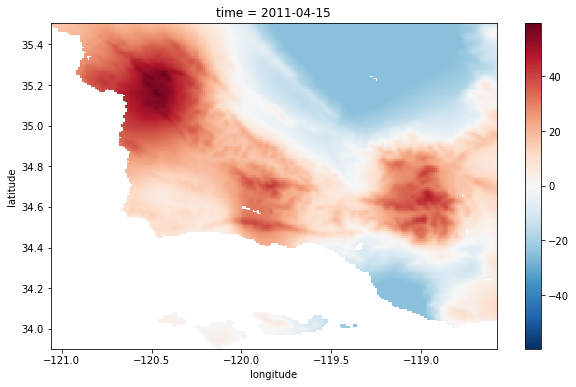

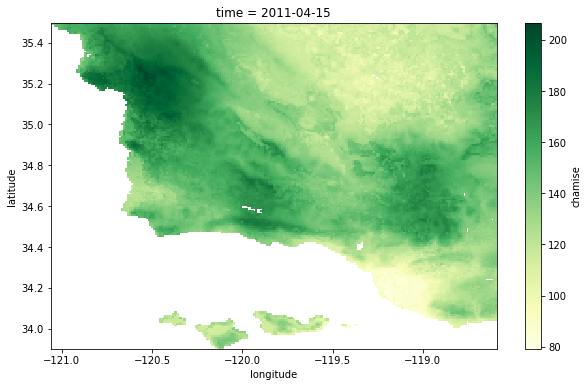

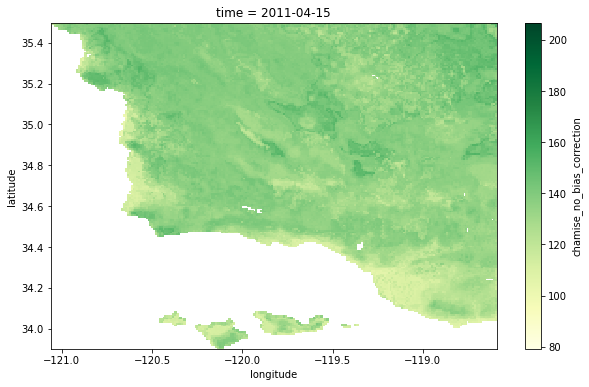

In [26]:
# Check bias correction, original chamise, and corrected chamise plots of time steps with largest negative correction
# i = 0 refers to largest negative correction
i = 0
min_value = lfm_ds['chamise'].sel(time=ex_values['min_20_times'][i]).min()
max_value = lfm_ds['chamise'].sel(time=ex_values['min_20_times'][i]).max()
bias_correction.sel(time=ex_values['min_20_times'][i]).plot(figsize=[10,6]);
lfm_ds['chamise'].sel(time=ex_values['min_20_times'][i]).plot(figsize=[10,6], vmin=min_value, vmax=max_value, cmap='YlGn');
lfm_ds['chamise_no_bias_correction'].sel(time=ex_values['min_20_times'][i]).plot(figsize=[10,6], vmin=min_value, vmax=max_value, cmap='YlGn');